In [1]:
%matplotlib inline
from astropy import table
import sys
import numpy as np
from scipy import integrate, interpolate, optimize
from pathlib import Path
import sinistra
import betterplotlib as bpl

bpl.set_style()

In [2]:
home_dir = Path("..").resolve()
data_dir = home_dir / "data"
krumholz_data_dir = home_dir / "pipeline" / "extra_cluster_data"

In [3]:
sys.path.append(str(krumholz_data_dir))
from read_clusters import read_clusters

In [32]:
galaxies = ["ngc628-e", "ngc7793-e", "ngc7793-w"]

def format_pdfs(galaxy):
    galaxy = galaxy.replace("-", "")
    file_name = f"{galaxy}_modp020_kroupalim_MW_phi0.50_ms2.0_ts0.5_pdf_1D.fits"
    cluster_data = read_clusters(krumholz_data_dir / f"krumholz_{galaxy}" / file_name)
    log_m = cluster_data["logm"]
    
    column_names = [
        "ID", 
        "m_16",
        "m_50",
        "m_84",
    ]
    
    galaxy_table = table.Table([[], [], [], []],
                               names=column_names,
                               dtype=[int, float, float, float])
    
    for cluster_idx in range(len(cluster_data["mpdf"])):
        mass_pdf = cluster_data["mpdf"][cluster_idx]
        cumulative_integral = integrate.cumtrapz(mass_pdf, x=log_m, initial=0)
        assert 0.99< cumulative_integral[-1] < 1.01
        
        # then figure out where the 16th, 50th, and 84th percentiles are
        # I could do this more precisely, but this is a rough approximation
        best_diff = {16: np.inf, 50: np.inf, 84: np.inf}
        best_idx = {16: np.nan, 50: np.nan, 84: np.nan}
        for idx in range(len(cumulative_integral)):
            for percentile in best_diff:
                this_diff = abs(cumulative_integral[idx] - percentile/100)
                if this_diff < best_diff[percentile]:
                    best_diff[percentile] = this_diff
                    best_idx[percentile] = idx

        best_log_m = {percentile: log_m[best_idx[percentile]] for percentile in best_idx}
        
        data_for_table = [
            cluster_data["cid"][cluster_idx],
            10**best_log_m[16],
            10**best_log_m[50],
            10**best_log_m[84]
        ]
        galaxy_table.add_row(data_for_table)
    return galaxy_table

Then I need to match these to their RA/Dec.

In [33]:
krumholz_ra_tables = {
    "ngc628-e": "ngc628e_cluster_legus_avgapcor_Gen_MWext_27Jun15.tab",
    "ngc7793-e": "ngc7793e_cluster_legus_avgapcor_Gen_MWext_28Jun15.tab",
    "ngc7793-w": "ngc7793w_cluster_legus_avgapcor_Gen_MWext_28Jun15.tab",
}

def read_krumholz_ra_dec_tables(galaxy):
    table_path = krumholz_data_dir / f"krumholz_{galaxy.replace('-', '')}" / krumholz_ra_tables[galaxy]
    krumholz_table = table.Table.read(str(table_path), format="ascii")
    krumholz_table.rename_column("col1", "ID")
    krumholz_table.rename_column("col4", "RA")
    krumholz_table.rename_column("col5", "Dec")
    krumholz_table.rename_column("col20", "mass_LEGUS_kversion")
    krumholz_table.rename_column("col34", "Class")
    
    to_delete = [col for col in krumholz_table.colnames 
                 if "col" in col]
    krumholz_table.remove_columns(to_delete)
    
    # Also restrict to good classes
    class_1_mask = krumholz_table["Class"] == 1
    class_2_mask = krumholz_table["Class"] == 2
    class_mask = np.logical_or(class_1_mask, class_2_mask)
    krumholz_table = krumholz_table[class_mask]
    # can remove class
    krumholz_table.remove_column("Class")
    
    return krumholz_table
    

Then a function to match them properly.

In [34]:
def read_krumholz_tables_full(galaxy):
    mass_catalog = format_pdfs(galaxy)
    ra_dec_catalog = read_krumholz_ra_dec_tables(galaxy)
    return table.join(mass_catalog, ra_dec_catalog, keys="ID")

In [35]:
krumholz_tables = {galaxy: read_krumholz_tables_full(galaxy) for galaxy in galaxies}

## Read my tables

In [36]:
my_tables = dict()
for gal_dir in data_dir.iterdir():
    if gal_dir.name in galaxies:
        mt_table_loc = gal_dir / "size" / "final_catalog_final_30_pixels_psf_my_stars_15_pixels_2x_oversampled.txt"
        my_tables[gal_dir.name] = table.Table.read(str(mt_table_loc), format="ascii.ecsv")

## Then match them based on RA/Dec

Make plots first

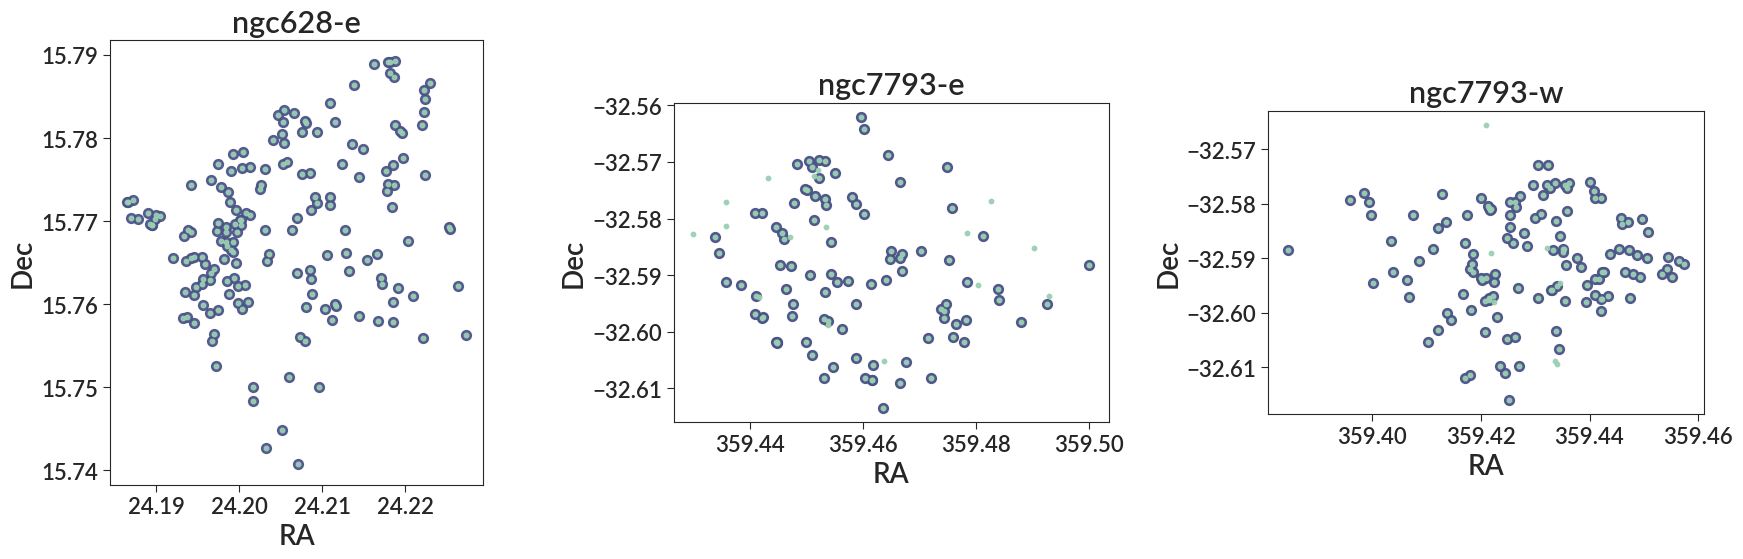

In [37]:
fig, axs = bpl.subplots(ncols=3, figsize=[18, 6])
for galaxy, ax in zip(galaxies, axs):
    ax.scatter(krumholz_tables[galaxy]["RA"], krumholz_tables[galaxy]["Dec"], 
               s=50, label="Krumholz")

    ax.scatter(my_tables[galaxy]["RA"], my_tables[galaxy]["Dec"], 
               s=10, label="Me")

#     ax.scatter(final_catalog["RA"], final_catalog["Dec"], 
#                c=bpl.color_cycle[3], s=12.5, label="Final")

    # whitmore_added = np.where(whitmore_table["Added"])
    # ax.scatter(whitmore_table["RAdeg"][whitmore_added], 
    #            whitmore_table["DEdeg"][whitmore_added], 
    #            s=10, c=bpl.color_cycle[3], label="Whitmore Added")
#     ax.legend()
    ax.equal_scale()
    ax.add_labels("RA", "Dec", galaxy)

This looks good, let's go ahead and match.

In [38]:
def do_matching(galaxy):
    kr_table = krumholz_tables[galaxy]
    my_table = my_tables[galaxy]
    
    matched_table = sinistra.astropy_helpers.symmetric_match(
        kr_table, my_table, max_sep=0.00001,
        ra_col_1="RA", dec_col_1="Dec",
        ra_col_2="RA", dec_col_2="Dec",
    )
    print("=====")
    print(galaxy)
    print("Krumholz Table length", len(kr_table))
    print("My Table length", len(my_table))
    print("Matched Table length", len(matched_table))
    print()
    return matched_table

In [39]:
matched_tables = {galaxy: do_matching(galaxy) for galaxy in galaxies}

=====
ngc628-e
Krumholz Table length 172
My Table length 172
Matched Table length 172

=====
ngc7793-e
Krumholz Table length 92
My Table length 108
Matched Table length 92

=====
ngc7793-w
Krumholz Table length 126
My Table length 135
Matched Table length 126



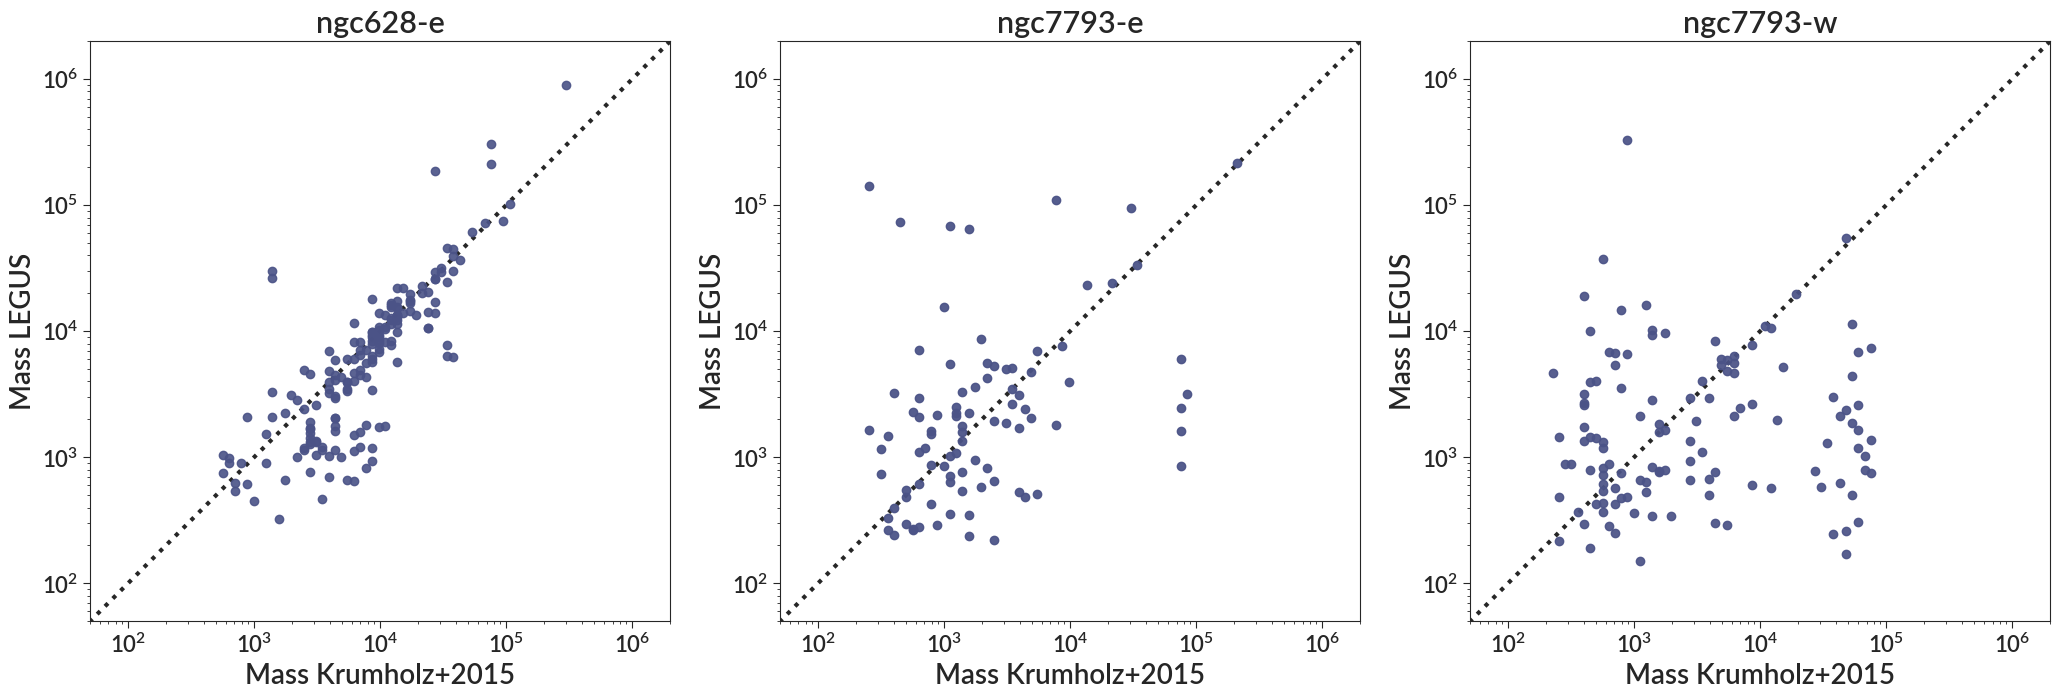

In [40]:
fig, axs = bpl.subplots(ncols=3, figsize=[21, 7])

for idx, field in enumerate(matched_tables):
    cat = matched_tables[field]
    ax = axs[idx]
    
    ax.equal_scale()
    ax.scatter(cat["m_50"], cat["mass_LEGUS_kversion"])
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.add_labels("Mass Krumholz+2015", "Mass LEGUS", field)
    ax.set_limits(50, 2e6, 50, 2e6)
    ax.plot([1, 1e7], [1, 1e7], ls=":", c=bpl.almost_black, zorder=0)

In [41]:
# fig, axs = bpl.subplots(ncols=2, nrows=2, figsize=[12, 12])
# axs = axs.flatten()
# for idx, field in enumerate(final_tables):
#     cat = matched_tables[field]
#     ax = axs[idx]
    
#     ax.equal_scale()
#     ax.scatter(cat["age_yr"], cat["age_yr"], alpha=0.3)
#     ax.set_xscale("log")
#     ax.set_yscale("log")
#     ax.add_labels("Age LEGUS", "Age Krumholz+2015")
#     ax.set_limits(5e5, 1e11, 5e5, 1e11)
#     ax.plot([1, 1e12], [1, 1e12], ls=":", c=bpl.almost_black, zorder=0)

# Plan 
- I'll have to use NGC7793 from the paper.